In [1]:
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.autograd import Variable
import torchvision
import pathlib
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from IPython.display import clear_output
from torch import nn, optim
from torchvision import transforms
from torchvision.datasets import ImageFolder

In [2]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
train_path = '../../pythonProject4/TRAIN'
test_path = '../../pythonProject4/TEST/test'

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
print(len(torchvision.datasets.ImageFolder(train_path,transform=transform)))
print(len(torchvision.datasets.ImageFolder(test_path,transform=transform)))

76598
9839


In [6]:
train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transform),
    batch_size=32, shuffle=True,
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transform),
    batch_size=32, shuffle=True
)

In [7]:
class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc = nn.Linear(32*26*26, num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = out.view(x.size(0), -1)
        out = self.fc(out)
        return out

In [9]:
nn_light = ConvNet(num_classes=4).to(device)
nn_light.load_state_dict(torch.load('oasis_model.pth', map_location=torch.device('cpu')))

In [ ]:
def train(model, train_loader, epochs, learning_rate, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    model.train()
    correct = 0
    total = 0

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            # inputs: A collection of batch_size images
            # labels: A vector of dimensionality batch_size with integers denoting class of each image
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # outputs: Output of the network for the collection of images. A tensor of dimensionality batch_size x num_classes
            # labels: The actual labels of the images. Vector of dimensionality batch_size
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}, Train Accuracy: {accuracy:.2f}%")

In [ ]:
def test(model, test_loader, device):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [ ]:
from pytorch_grad_cam import GradCAM,GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image,preprocess_image
import PIL
import cv2

In [13]:
def grad_cam_f(path):
    cam_f = GradCAM(model=nn_light, target_layers=nn_light.conv3) # use GradCamPlusPlus class
    img = np.array(PIL.Image.open(path))
    img = cv2.resize(img, (224,224))
    img = np.float32(img) / 255
    input_tensor = preprocess_image(img)
    grayscale_cams = cam_f(input_tensor=input_tensor)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
    cam = np.uint8(255*grayscale_cams[0, :])
    cam = cv2.merge([cam, cam, cam])
    images = np.hstack((np.uint8(255*img), cam_image))
    return images

In [14]:
images = grad_cam_f('../../pythonProject4/TEST/test/Very mild Dementia/OAS1_0003_MR1_mpr-1_100.jpg')

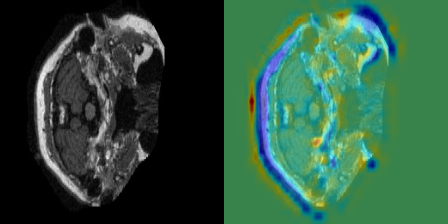

In [15]:
PIL.Image.fromarray(images)

In [16]:
def grad_cam_f_1(path):
    cam_f = GradCAM(model=nn_light, target_layers=nn_light.conv3) # use GradCamPlusPlus class
    img = np.array(PIL.Image.open(path))
    img = cv2.resize(img, (224,224))
    img = np.float32(img) / 255
    input_tensor = preprocess_image(img)
    grayscale_cams = cam_f(input_tensor=input_tensor)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
    cam = np.uint8(255*grayscale_cams[0, :])
    cam = cv2.merge([cam, cam, cam])
    images = np.hstack((np.uint8(255*img), cam_image))
    return images

In [17]:
images = grad_cam_f_1('../../pythonProject4/TEST/test/Very mild Dementia/OAS1_0003_MR1_mpr-1_100.jpg')

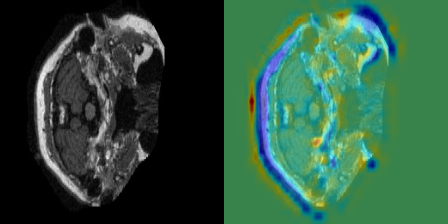

In [18]:
PIL.Image.fromarray(images)

In [10]:
import captum
from captum.attr import LRP

In [11]:
test_dataset = torchvision.datasets.ImageFolder(test_path,transform=transform)

Mild Dementia


C:\Users\arink\AppData\Local\Programs\Python\Python310\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


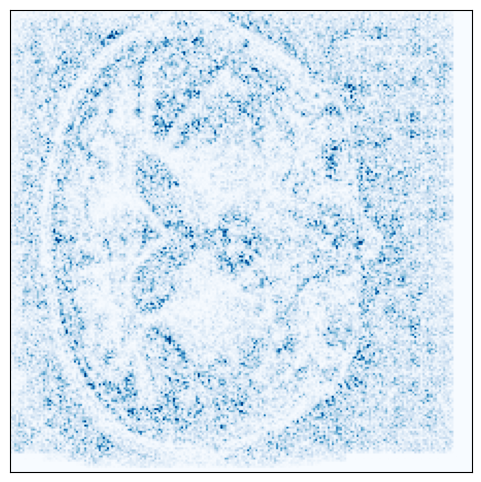

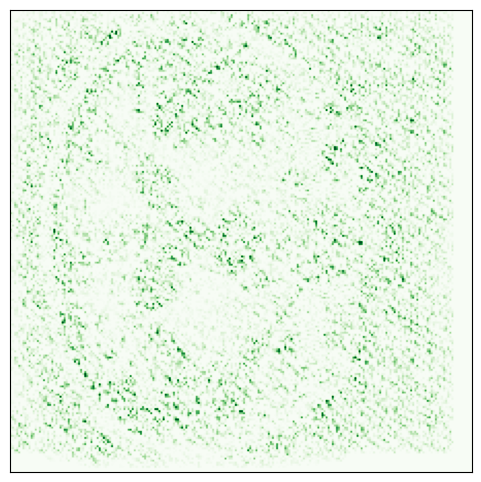

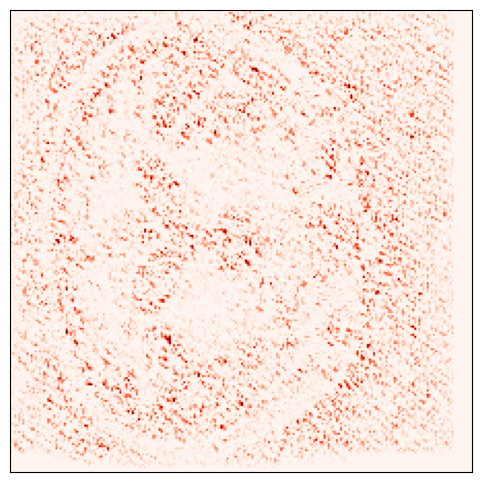

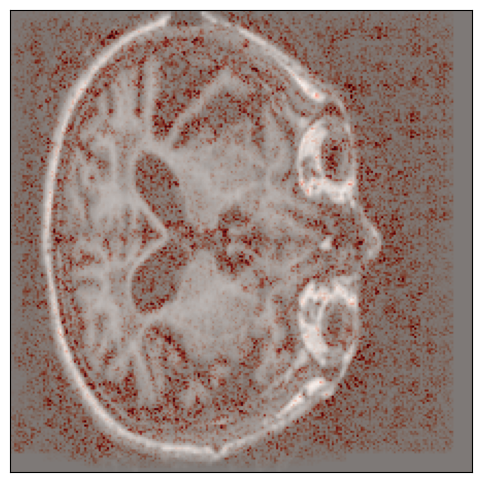

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [12]:
lrp = LRP(nn_light)
image_id = 100
X = test_dataset[image_id][0]
print(test_dataset.classes[test_dataset[image_id][1]])
X = X.unsqueeze(0)
input = X.to(device)
attribution = lrp.attribute(input, target=test_dataset[image_id][1])
image = np.transpose(attribution.to('cpu').detach().numpy().squeeze(), (1, 2, 0))
captum.attr.visualization.visualize_image_attr(image)
captum.attr.visualization.visualize_image_attr(image, sign='positive')
captum.attr.visualization.visualize_image_attr(image, sign='negative')
origin_image = np.transpose(test_dataset[image_id][0].to('cpu').detach().numpy().squeeze(), (1, 2, 0))
captum.attr.visualization.visualize_image_attr(image, method='blended_heat_map', cmap='Reds', original_image=origin_image)